# Week Ten - Assignment: Document Classification
 
## *Instructions*

*It can be useful to be able to classify new "test" documents using already classified "training" documents.  A common example is using a corpus of labeled spam and ham (non-spam) e-mails to predict whether or not a new document is spam.  Here is one example of such data:  [UCI Machine Learning Repository: Spambase Data Set](http://archive.ics.uci.edu/ml/datasets/Spambase).*

*For this project, you can either use the above dataset to predict the class of new documents (either withheld from the training dataset or from another source such as your own spam folder).*

*For more adventurous students, you are welcome (encouraged!) to come up a different set of documents (including scraped web pages!?) that have already been classified (e.g. tagged), then analyze these documents to predict how new documents should be classified.*

In [5]:
# Load libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import zipfile
import io
import requests

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, recall_score, classification_report
from sklearn.tree import plot_tree
from sklearn.multiclass import OneVsRestClassifier

from imblearn.under_sampling import RandomUnderSampler

import xgboost as xgb
import graphviz

from collections import Counter

## Import the Spambase Dataset

In [6]:
# Download the zip file from the internet
url = "https://archive.ics.uci.edu/static/public/94/spambase.zip"
response = requests.get(url)

# Extract spambase.zip from the downloaded zip
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    # Extract spambase.data from spambase.zip
    with z.open('spambase.data') as csvfile:
        spambase_data = pd.read_csv(csvfile, sep=',', header=None)
        
spambase_data.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [7]:
# Rename columns
column_names = [
    "word_freq_make",
    "word_freq_address",
    "word_freq_all",
    "word_freq_3d",
    "word_freq_our",
    "word_freq_over",
    "word_freq_remove",
    "word_freq_internet",
    "word_freq_order",
    "word_freq_mail",
    "word_freq_receive",
    "word_freq_will",
    "word_freq_people",
    "word_freq_report",
    "word_freq_addresses",
    "word_freq_free",
    "word_freq_business",
    "word_freq_email",
    "word_freq_you",
    "word_freq_credit",
    "word_freq_your",
    "word_freq_font",
    "word_freq_000",
    "word_freq_money",
    "word_freq_hp",
    "word_freq_hpl",
    "word_freq_george",
    "word_freq_650",
    "word_freq_lab",
    "word_freq_labs",
    "word_freq_telnet",
    "word_freq_857",
    "word_freq_data",
    "word_freq_415",
    "word_freq_85",
    "word_freq_technology",
    "word_freq_1999",
    "word_freq_parts",
    "word_freq_pm",
    "word_freq_direct",
    "word_freq_cs",
    "word_freq_meeting",
    "word_freq_original",
    "word_freq_project",
    "word_freq_re",
    "word_freq_edu",
    "word_freq_table",
    "word_freq_conference",
    "char_freq_;",
    "char_freq_(",
    "char_freq_sq_bracket", # feature_names must be string, and may not contain [, ] or <
    "char_freq_!",
    "char_freq_$",
    "char_freq_#",
    "capital_run_length_average",
    "capital_run_length_longest",
    "capital_run_length_total",
    "spam"
]

spambase_data.columns = column_names
spambase_data.head()


,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_sq_bracket,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


## Exploratory Data Analysis (EDA)

In [13]:
# Check missingness
null_column_counts = spambase_data.isnull().sum()
if len(null_column_counts[null_column_counts > 0]) > 0:
    print('The below columns have missing values:')
    print(spambase_data.isnull().sum()[spambase_data.isnull().sum() > 0])

else:
    print('No missing values detected.')

No missing values detected.


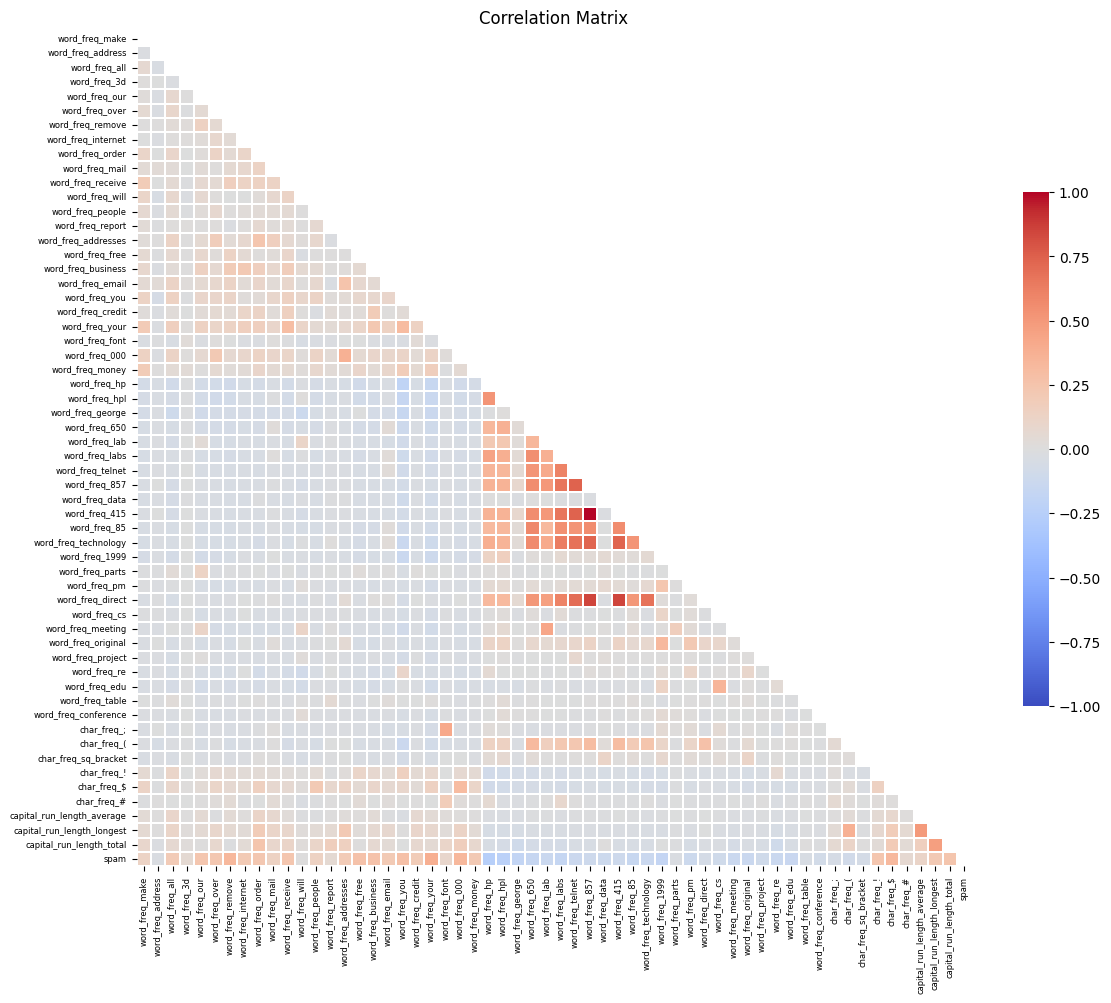

`word_freq_857` is highly positively correlated with `word_freq_415` (1.00).
`word_freq_857` is highly positively correlated with `word_freq_direct` (0.85).
`word_freq_415` is highly positively correlated with `word_freq_direct` (0.85).
`word_freq_telnet` is highly positively correlated with `word_freq_857` (0.74).
`word_freq_telnet` is highly positively correlated with `word_freq_415` (0.74).
`word_freq_857` is highly positively correlated with `word_freq_technology` (0.73).
`word_freq_415` is highly positively correlated with `word_freq_technology` (0.73).
`word_freq_telnet` is highly positively correlated with `word_freq_direct` (0.70).


In [14]:
# Create correlation matrix for numeric columns only
corr_matrix = spambase_data.select_dtypes(include=[np.number]).corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) 
cols = corr_matrix.columns
ax = sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    center=0,
    square=True,
    linewidths=0.1,
    cbar_kws={'shrink': 0.6}
)
ax.set_xticks(np.arange(len(cols)) + 0.5) # Ensure every tick/label is shown 
ax.set_yticks(np.arange(len(cols)) + 0.5)
ax.set_xticklabels(cols, rotation=90, fontsize=6)
ax.set_yticklabels(cols, rotation=0, fontsize=6)
plt.tight_layout()
plt.title('Correlation Matrix')
plt.xticks(rotation=90, fontsize=6)
plt.yticks(rotation=0, fontsize=6)
plt.show()

# Get the absolute correlation matrix and set diagonal to 0 to ignore self-correlation
high_corr = corr_matrix.unstack().to_frame('correlation') # Unstack the correlation matrix
high_corr['sign'] = np.where(high_corr['correlation'] >= 0, 'positive', 'negative') # Add a new column indicating if the correlation is positive or negative
high_corr['correlation'] = high_corr['correlation'].abs().drop_duplicates()
high_corr = high_corr[high_corr['correlation'] < 1]
high_corr = high_corr.sort_values(by='correlation', ascending=False)
for (var1, var2), row in high_corr.head(8).iterrows():
    print(f"`{var1}` is highly {row['sign']}ly correlated with `{var2}` ({row['correlation']:.2f}).")


A few of the features appear to be correlated. E.g., the frequency of some of the numbers(assuming these are commmonly used area codes in spam messages) and the words "direct", "telnet", and "technology".

In [15]:
# Check duplicate rows
df_duplicates = spambase_data[spambase_data.duplicated()]
print(f"There are {df_duplicates.shape[0]:,} duplicate emails ({100*round(df_duplicates.shape[0]/spambase_data.shape[0],3)}% of total)")

# Drop duplicate rows
df_deduped = spambase_data.copy()
df_deduped = df_deduped.drop_duplicates(keep='first')
print(f"Number emails after dropping copies: {df_deduped.shape[0]:,}")
print("Spam counts:", Counter(df_deduped['spam']), "({:.1f}%)".format(100*Counter(df_deduped['spam'])[1]/df_deduped.shape[0]))


There are 391 duplicate emails (8.5% of total)
Number emails after dropping copies: 4,210
Spam counts: Counter({0: 2531, 1: 1679}) (39.9%)


We found 391 duplicate entries, and it is unlikely that these emails would actually have all 58 features exactly the same. Therefore, we will drop these copies before training our models--they are likely erroneous.

## Splitting our data

For our project, we'll split our data into a training and test dataset and balance the data so that there are equal numbers of spam and non-spam emails. We know there are 4,210 (unduplicated) observations in this data, 39.9% of which are spam. We split data into 265 emails for the test set, 265 emails for the dev-test set, and the remaining 3,680 emails for the training set.

In [16]:
def split_data(df, verbose=True):
    x = df.drop('spam', axis=1)
    y = df['spam']

    # Split into test (265), dev-test (265), and training (remaining)
    x_temp, x_test, y_temp, y_test = train_test_split(
        x, y, test_size=265, random_state=1, stratify=y    # Stratify to keep spam balance
    )
    x_train, x_devtest, y_train, y_devtest = train_test_split(
        x_temp, y_temp, test_size=265, random_state=1, stratify=y_temp
    )

    # Print a summary of the split data (only if verbose=True)
    if verbose:
        print("Distribution after Stratified Split:")
        print("Training set size:", len(y_train))
        print("Training set counts:", Counter(y_train))
        print("Dev-test set size:", len(y_devtest))
        print("Dev-test set counts:", Counter(y_devtest))
        print("Test set size:", len(y_test))
        print("Test set counts:", Counter(y_test))

    rus = RandomUnderSampler(random_state=1)

    # Apply the sampling only to the training set
    x_train_resampled, y_train_resampled = rus.fit_resample(x_train, y_train)

    # Print a summary of the final data (only if verbose=True)
    if verbose:
        print("\nDistribution after Balancing Training Set:")
        print(f"Total balanced training samples: {len(y_train_resampled)}")
        print("New (Balanced) Training set counts:", Counter(y_train_resampled))
    
    # Return all three sets
    return x_train_resampled, x_devtest, x_test, y_train_resampled, y_devtest, y_test

x_train_resampled, x_devtest, x_test, y_train_resampled, y_devtest, y_test = split_data(df_deduped)

Distribution after Stratified Split:
Training set size: 3680
Training set counts: Counter({0: 2213, 1: 1467})
Dev-test set size: 265
Dev-test set counts: Counter({0: 159, 1: 106})
Test set size: 265
Test set counts: Counter({0: 159, 1: 106})

Distribution after Balancing Training Set:
Total balanced training samples: 2934
New (Balanced) Training set counts: Counter({0: 1467, 1: 1467})


## Building our models

### Iteration 1: Baseline Models

We'll try the following models:

1. **XGBoost Classifier**: Robust to correlated predictors and noisy features and provides feature importance for easy interpretation.  
2. **Random Forest Classifier**: Good for data with many features, some of which may be correlated.
3. **Logistic Regression Classifier**: Good for binary classification (spam vs. non-spam).

> Note: Since Naive Bayes assumes feature independence, and we have found some correlated features in our EDA, we will not be using Naive Bayes for this project.

In [17]:
def train_classifiers(X_train, y_train):
    # Initialize RF
    forest = RandomForestClassifier(n_estimators=25, random_state=1, n_jobs=2)
    
    # Initialize XGBoost
    xgboost = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.01, max_depth=4, random_state=1)

    # Initialize Logistic Regression
    lr = OneVsRestClassifier(LogisticRegression(C=100.0, solver='lbfgs', max_iter=7000))

    # Return trained classifiers
    return(
        {
            'XGBoost': xgboost.fit(X_train, y_train),
            'RF': forest.fit(X_train, y_train),
            'LogReg': lr.fit(X_train, y_train)
        }
    )

# Train classifiers on resampled training data
first_round_bathroom_classifiers = train_classifiers(x_train_resampled, y_train_resampled)

In [18]:
for name, classifier in first_round_bathroom_classifiers.items():
    # Accuracy on (resampled) training set
    train_acc = accuracy_score(y_train_resampled, classifier.predict(x_train_resampled))
    print(f"{name} Training Accuracy: {train_acc * 100:.5f}%")

    # Accuracy on dev test set
    dev_acc = accuracy_score(y_devtest, classifier.predict(x_devtest))
    print(f"{name} Dev-Test Accuracy: {dev_acc * 100:.5f}%")
    
    print(f"{name} Classification Report on Test Set:")
    print(classification_report(y_devtest, classifier.predict(x_devtest)))

XGBoost Training Accuracy: 96.18269%
XGBoost Dev-Test Accuracy: 95.84906%
XGBoost Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       159
           1       0.95      0.94      0.95       106

    accuracy                           0.96       265
   macro avg       0.96      0.96      0.96       265
weighted avg       0.96      0.96      0.96       265

RF Training Accuracy: 99.86367%
RF Dev-Test Accuracy: 95.84906%
RF Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       159
           1       0.94      0.95      0.95       106

    accuracy                           0.96       265
   macro avg       0.96      0.96      0.96       265
weighted avg       0.96      0.96      0.96       265

LogReg Training Accuracy: 92.77437%
LogReg Dev-Test Accuracy: 92.45283%
LogReg Classification Report on Test Set:
             

On the first round of models with our feature we find that the XGBoost and the Random Forest classifiers perform the best, both correctly classifying 95.8% of the dev-test emails. However, random forests appears to be overfitting the training data, with a training accuracy of 99.86%, so we prefer the XGBoost model, which has a more reasonable training accuracy of 96.2%.

We visualize the feature importance from the XGBoost model below.

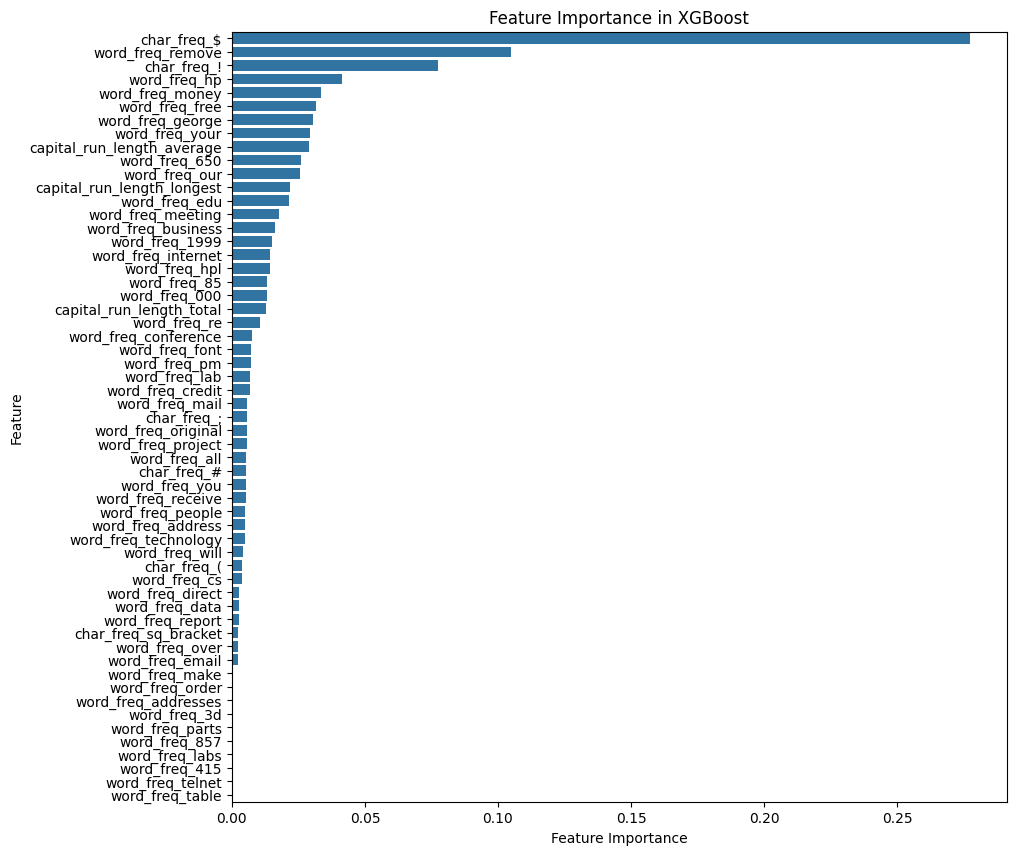

In [19]:
# Feature importances
importances = pd.Series(first_round_bathroom_classifiers['XGBoost'].feature_importances_, index=x_train_resampled.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,10))
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importance in XGBoost")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

The most important features appear to be `char_freq_$`, `word_freq_remove`, and `word_freq_!`, which makes sense intuitively as these are common in spam emails trying to scam victims out of money or urging them to take action.

The highly correlated features we found in our EDA (e.g., `word_freq_telnet`, `word_freq_857`, `word_freq_415`) do not appear to be very important in this model. This is likely because XGBoost is robust to correlated predictors, so it can select the most important features among correlated groups. 

### Iteration 2: Hyperparameter Tuning

Next, we will tune the hyperparameters of our XGBoost model using grid search with cross-validation to see if we can improve performance.

In [20]:
# Now we'll set up our grid search
param_grid = {
    'n_estimators': list(range(20, 301, 25)),
    'learning_rate': [round(x, 2) for x in np.arange(0.1, 1.01, 0.05)],
}

# Initialize XGBoost
xgboost2 = xgb.XGBClassifier(random_state=1)

grid_search = GridSearchCV(
    estimator=xgboost2,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1 # With our wide range of hyperparameters, we're going to need to use all available cores to speed up the training
)

# Run the grid search on the resampled training data
grid_search.fit(x_train_resampled, y_train_resampled)

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'learning_rate': [np.float64(0.1), np.float64(0.15), ...], 'n_estimators': [20, 45, ...]}"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [21]:
print(f"Best Hyperparameters Found: {grid_search.best_params_}")
best_xgboost = grid_search.best_estimator_

# Accuracy on (resampled) training set
train_acc = accuracy_score(y_train_resampled, best_xgboost.predict(x_train_resampled))
print(f"XGBoost Training Accuracy: {train_acc * 100:.5f}%")

# Accuracy on dev test set
dev_acc = accuracy_score(y_devtest, best_xgboost.predict(x_devtest))
print(f"XGBoost Dev-Test Accuracy: {dev_acc * 100:.5f}%")

print(f"XGBoost Classification Report on Test Set:")
print(classification_report(y_devtest, best_xgboost.predict(x_devtest)))

Best Hyperparameters Found: {'learning_rate': np.float64(0.3), 'n_estimators': 70}
XGBoost Training Accuracy: 99.28425%
XGBoost Dev-Test Accuracy: 94.71698%
XGBoost Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       159
           1       0.93      0.93      0.93       106

    accuracy                           0.95       265
   macro avg       0.94      0.94      0.94       265
weighted avg       0.95      0.95      0.95       265



The grid search yielded a learning rate of 0.3 with 70 estimators. The accuracy of our tuned model went down slightly from 95.85% in the un-tuned model to 94.72% in the tuned model. The macro recall also went down from 96% to 94% in this tuned model.

Since our tuned model did not improve performance, we will stick with our original XGBoost model with 1,000 estimators, a learning rate of 0.01, and a max_depth of 4 for predicting spam vs. non-spam emails and move on to testing it on our final test dataset.

## Final Evaluation on Test Set

Now that we're satisfied with our best model from the two dev test iterations, we evaluate it on the held-out test set to get a final estimate of "real-world" performance.

In [23]:
# Final evaluation on the test set
xgb_model = first_round_bathroom_classifiers['XGBoost'] # Use the trained XGBoost classifier from our first round classifiers

# Dev-test accuracy
devtest_accuracy = accuracy_score(y_devtest, xgb_model.predict(x_devtest))
print(f"\nDev-Test Accuracy: {devtest_accuracy * 100:.2f}%")

# Test set accuracy
test_accuracy = accuracy_score(y_test, xgb_model.predict(x_test))
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Compare the two
difference = test_accuracy - devtest_accuracy
print(f"\nDifference (Test - Dev-Test): {difference * 100:.2f} percentage points")



Dev-Test Accuracy: 95.85%
Test Accuracy: 96.23%

Difference (Test - Dev-Test): 0.38 percentage points


The dev-test and test accuracy are very similar-within 1 percentage point of eachother-indicating that our model generalizes well and is not overfitted. This is in line with our expectations. This model accurately classifies about 96% of emails in the test set as spam or non-spam, which is quite good performance for this task.

## References

Hopkins, M., Reeber, E., Forman, G., & Suermondt, J. (1999). Spambase [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C53G6X.